In [40]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import constants as const
!pip install openpyxl

# Introduction


In this computational essay i will use publicly available weather data from the meterological institute. The weather data is historical data, meaning that i have different measurements like, rainfall, snow, and temperature for a given weather station. I want to find the seasons in the weather data using the different measurements. We know that the weather usually follows a periodic repeating pattern on a macro level, i.e the different seasons. Another issue with weather data is that it is not always clean and fully representing the actual attributes measured. For example, the temperature sensor could be effected by the heat of the station equipment or just the heat from the buildings in the surrounding areas.  

# Theory and Method


I will use fourier to detect and clean noise from the data. The goal here is to show the power of fourier analysis and also show that most things around us are periodic and can be analyzed further with fourier. One interesting question i want to answer after my analysis is: Have the seasons been delayed in the last 20 years? Can we see any signs of climate change by looking at the results of the fourier analysis? I will look at data from 3 weather stations spread over Norway. This will give a better understanding of the seasons in Norway and if there has been changes during the last 20 years. 

### Quick introduction to  weather data gathering and analysis

Weather is a huge part of our live eventhough we may not think about it. It effects everything from what you should wear on a day to day basis to how your phone, computer or any digital device you use works. Weather is a part of our atmosphere on our planet, and the atmoshpere stretches from the surface of our planet where we do alot of these measurements to more than 600 miles (approx 1000km) straight up in the sky. This causes the measurements to be uncertain and noisy depending on the parameter its measuring. In the sketch below you can see the surface of our planet, and the atmoshpere stretching up. Most of what we call weather is created in the lower parts of the atmosphere, also the temperature, pressure and air density changes gradually when moving upwards in the atmosphere. The sketch shows 4 of the main layers of the atmosphere in correct order, than the plot below the sketch is showing the change in pressure and density as a function of height in the atmosphere 

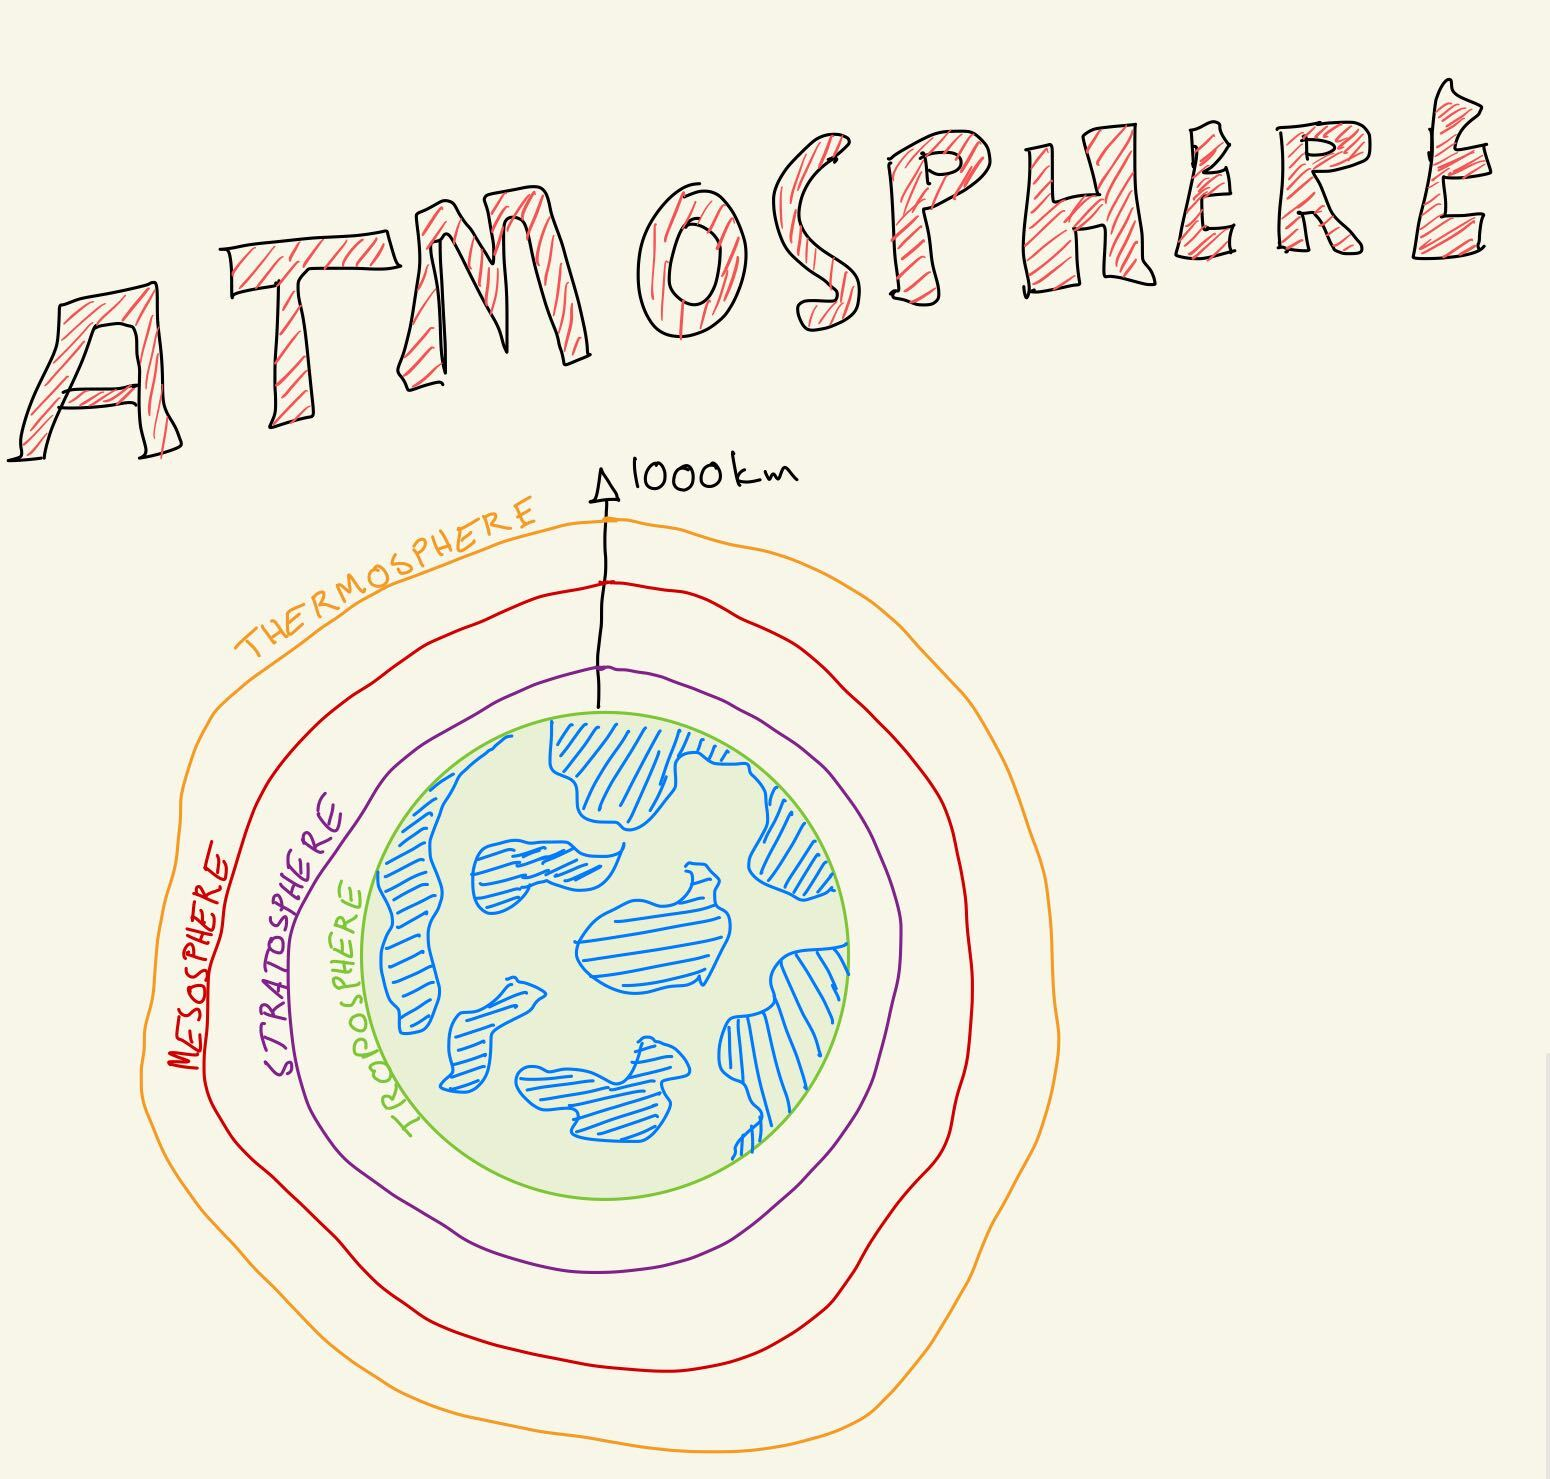

Pressure and density gradient as a function of height in the atmosphere is shown below

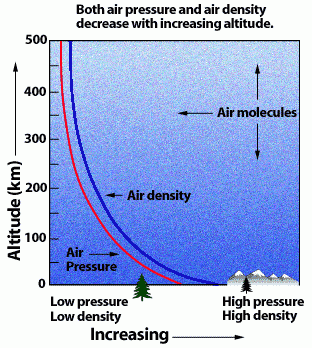

Image source: https://www.worldatlas.com/articles/how-high-is-the-earth-s-atmosphere.html

### Quick introduction to  Fourier Analysis

Fourier analysis is a powerful mathematical method to understand signals and data, clean data and gain better insights. Fouriers power lays in the fact that it allows us to represent any periodic signal/input data using trigonometric functions. FFT or fast fourier transform is the first step in our analysis. Lets imagine a simple signal that has evenly spaced, meaning that the distance/time between each sample is the same. The DFT is  calculated with the following equation [1]:

$ X_k = \frac{1}{N} \left(\sum_{n=0}^{n-1}x_n e^{-i \frac{2 \pi}{N}kn}\right)$

Where $x_n$ is the input data/signal and and $x_k$ is the transformed data in the frequency domain. In our work we will use the frequency plot to decide a cutoff for the data and we will do an inverse fourier transform to get a clean and noisfree signal so we can easier understand what it means. 

The Inverse fourier transform lets us go back to the time domain from the frequency domain for a signal for example. In our case the IFFT will let us go back from the frequency domain of average temperature to the frequency domain with magnitudes on the y-axis to the time domain with the temperature data or any other weather data measured over time. The IFFT is given by the following equation which is very similar to the function above for the DFT.

$ X_k =\sum_{k=0}^{N-1}X_K e^{-i \frac{2 \pi}{N}kn}$

To give you as a reader a better understanding of fourier analysis i will use a wav file and read the sound from the file using scipy and go from the time domain to the frequency domain and back again. I will also use this opportunity to explain phenomena such as aliasing, nyquist and the sampling theorem which are fundamentals in fourier analysis. 

Samplerate:  48000
T:  2.1609166666666666


Text(0.5, 0, 't [s]')

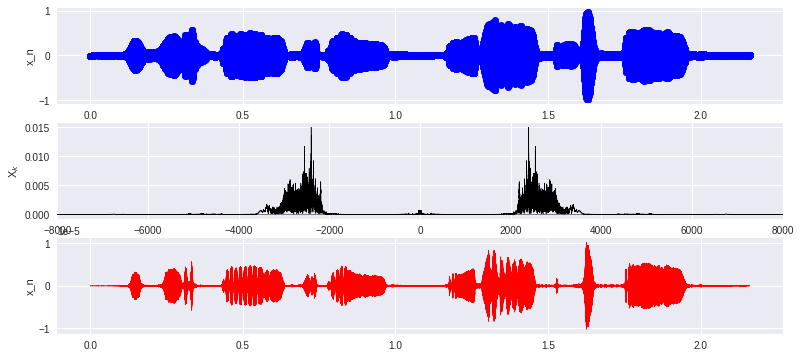

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

path = "/home/jupyter/FYS2130SVIBOL/mistle_thrush.wav"

samplerate, data = wavfile.read(path)

x_n = data[:,0]
N = data.shape[0]
f_samp = samplerate
T = N/f_samp
dt = 1/f_samp
t = dt*np.linspace(0,N,N)
print("Samplerate: ", samplerate)
print("T: ", T)

X_k = np.fft.fft(x_n)*(1/N)
freq = np.fft.fftfreq(N,dt)

X_k_copy = X_k.copy()

X_k_copy[np.abs(freq) > 3000] = 0
X_k_copy[np.abs(freq)<1100 ] = 0

ift = np.fft.ifft(X_k_copy)
# plots
fig, ax = plt.subplots(3,1, figsize = (13, 6))
ax[0].grid(1)
ax[1].grid(1)
ax[0].plot(t, x_n, color='blue', linestyle='solid', marker='o')
ax[0].set_xlabel('t [s]')
ax[0].set_ylabel('x_n')
#

ax[1].plot(freq, np.abs(X_k), color='black', linewidth=0.5)
ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('X$_k$')
ax[1].set_xlim(-8000,8000)

ax[2].plot(t, ift, color='red', linewidth=0.5)
ax[2].set_ylabel('x_n')
ax[1].set_xlabel('t [s]')

In the 3 plots above we see first the original signal in blue, in the second plot we have applied the FFT function from numpy and done a one dimensional discrete fourier transform. We have plotted both negative and positive values and we have moved to the frequency domain. Based on this second plot i have decided a cutoff area where we dont have any "interesting" frequencies. This area is somewhere above 2000 Hz and below 4000 Hz. Based on these values we have applied the cutoff to a copy of the original data and then we have done an inverse fourier transform to go back to the time domain. The new recreated signal is shown in red in the last plot above and matches the original signal in the blue plot. From the syllabus we know the sampling theorem which tells us that the sampling rate must meet the requirement for nyquist frequency, which means that the sampling rate must be at least twice the highest frequency in the signal. If this requirement is not met, the phenomena of Aliasing and folding will occur. There are "aliases" or copies of the frequency in the wrong parts of the frequency spectrum. The folding symmetry phenomena is shown in the image below. The blue line in the first plot is a synthethic signal in the time domain, but the folding symmetry is shown in the second plot and the relevant part is marked with red circles

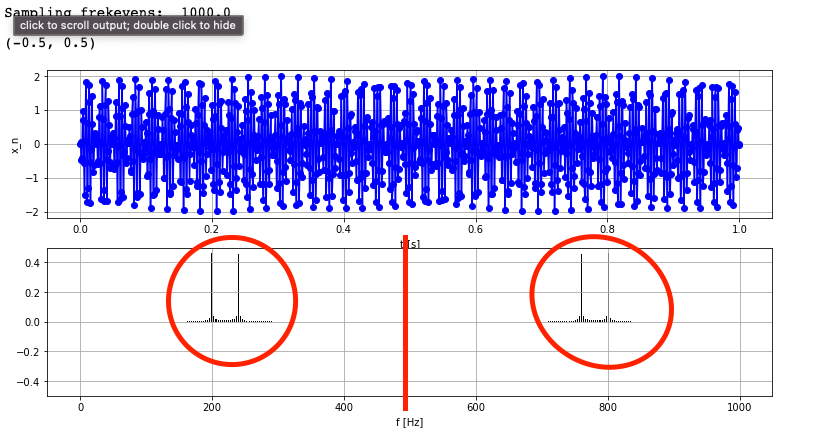

Source: My own oblig delivery (nr6)

### Numerical Analysis and code

In this section i have made a WeatherAnalysis class which can take in a excel spreadsheet as input, parse the data and plot it, analyze it and present the results. 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import matplotlib.transforms as mtransforms
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from numpy.fft import rfft, irfft, rfftfreq
from scipy import pi, signal, fftpack

class WeatherAnalysis():
    def __init__(self,inputData):
        self.df = pd.read_excel(inputData)
        self.df.replace('-',np.nan, inplace = True)
        #self.df["Tid(norsk normaltid)"] = self.df["Tid(norsk normaltid)"].astype(str)
        #self.df['ConvertedDate'] = self.df['Tid(norsk normaltid)'].dt.strftime('%d/%m/%Y')
        self.df['Tid(norsk normaltid)'] = pd.to_datetime(self.df['Tid(norsk normaltid)'], errors='coerce')
        self.df['Tid(norsk normaltid)'] = self.df['Tid(norsk normaltid)'].dt.strftime('%d/%m/%Y')
        self.df["Tid(norsk normaltid)"] = self.df["Tid(norsk normaltid)"].astype("datetime64")
        self.df = self.df.set_index("Tid(norsk normaltid)")
        #self.df.drop(self.df[self.df['Nedbør (døgn)']== '-'].index, inplace = True)
        #self.df.replace(np.nan,'-', inplace = True)
        self.df.dropna(inplace= True)
        #self.df = self.df.loc[self.df.index > '2016']
    
        print("File contains following columns: ")
        print("__________________________________")
        for col in self.df.columns.values.tolist():
            print(col)
        print("__________________________________")
        print("__________________________________")
        print("_______  STATISTICS__________")
        print(self.df.describe())
        
        

    
    #In the function below we plot the timeseries data read from the datafile that is read as pandas dataframe
    #I have "hardcoded" this below since the column names are equal for all files collected from the 
    #data source, this is not the optimal way if you want to create a class that works universally ofcourse.
    def plotData(self):
        plt.style.use('seaborn')
        plt.rcParams["figure.figsize"] = (16, 8)
        plt.title("Precipitation")
        sns.lineplot(x = self.df.index, y = self.df['Nedbør (døgn)'], data = self.df)
        plt.ylabel("Precipitation (mm)")
        plt.xticks(rotation = 25)
        plt.show()
        
        plt.title("Maximum Air Temperature")
        sns.lineplot(x = self.df.index, y = self.df['Maksimumstemperatur (døgn)'], data = self.df)
        plt.ylabel("Maximum Air Temperature (Celcius)")
        plt.show()
        
        
        plt.title("Average Air Temperature")
        sns.lineplot(x = self.df.index, y = self.df['Middeltemperatur (døgn)'], data = self.df)
        plt.ylabel("Average Air Temperature (Celcius)")
        plt.show()
        
        plt.title("Snowfall")
        sns.lineplot(x = self.df.index, y = self.df['Snødybde'], data = self.df)
        plt.ylabel("Snowdepth (mm)")
        plt.show()
        
    #Here i do the fourier analysis
    def Analysis(self,inp):
        samplerate = 1
        N = self.df.shape[0]
        f_samp = samplerate
        T = N/f_samp
        print("Period: ",T)
        dt = 1/f_samp
        fftVal  = np.fft.fft(self.df[inp])
        measFFT = np.abs(fftVal) ** 2
        fftfreq = np.fft.fftfreq(N,dt)
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(fftfreq[fftfreq > 0], 10 * np.log10(measFFT[fftfreq > 0]))
        #ax.set_xlim(0, 5)
        ax.set_xlabel('Frequency (1/day)')
        ax.set_ylabel('Magnitude')


    #Inverse Fourier transform and cutoff
    def cutandIFFT(self,inp,cutOff, ylab):

        samplerate = 1
        N = self.df.shape[0]
        f_samp = samplerate
        T = N/f_samp
        dt = 1/f_samp
        fftVal  = np.fft.fft(self.df[inp])
        measFFT = np.abs(fftVal) ** 2
        fftfreq = np.fft.fftfreq(N,dt)
        

        fftCopy = fftVal.copy()
        fftCopy[np.abs(fftfreq) > cutOff] = 0

        temp_slow = np.real(np.fft.ifft(fftCopy))
        fig, ax = plt.subplots(1, 1, figsize=(18, 6))
        self.df[inp].plot(ax=ax, lw=.5)
        ax.plot_date(self.df.index, temp_slow)
        ax.set_xlabel('Date')
        ax.set_ylabel(ylab)
        plt.show()

        
    
        


    
        

First we read in the file for Blindern weather station and we are presented with the different measurements from that station in the given file

In [43]:
wet = WeatherAnalysis("table_Blindern.xlsx")

File contains following columns: 
__________________________________
Navn
Stasjon
Maksimumstemperatur (døgn)
Middeltemperatur (døgn)
Snødybde
Nedbør (døgn)
Middel av middelvind fra hovedobs. (døgn)
__________________________________
__________________________________
_______  STATISTICS__________
       Maksimumstemperatur (døgn)  Middeltemperatur (døgn)     Snødybde  \
count                 7907.000000              7907.000000  7907.000000   
mean                    11.047970                 7.134046     4.736689   
std                      9.101038                 8.032726    11.271447   
min                    -15.600000               -18.100000     0.000000   
25%                      3.800000                 1.100000     0.000000   
50%                     10.900000                 6.800000     0.000000   
75%                     18.700000                14.000000     0.000000   
max                     34.600000                25.900000    67.000000   

       Nedbør (døgn)  Midd

Now we use the plot method and plot the timeseries data. We have the measurements on the y-axis in each plot and the dates (timeseries) on the x-axis

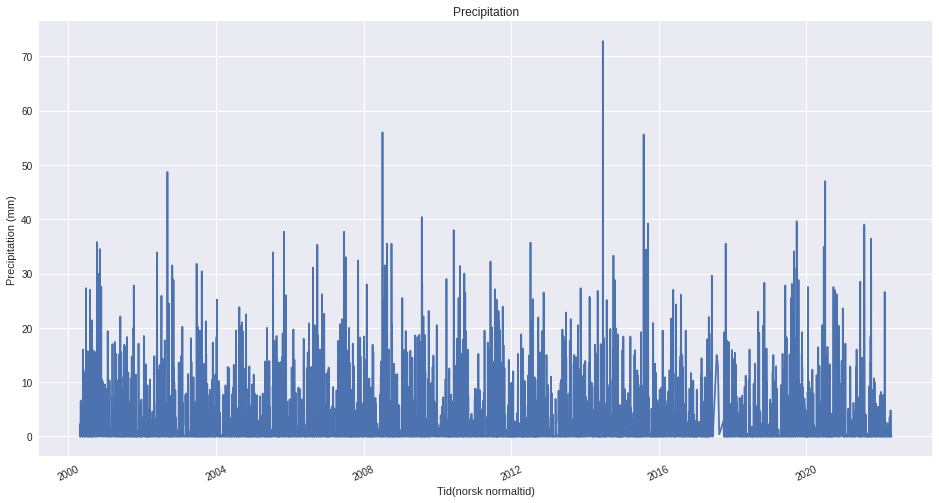

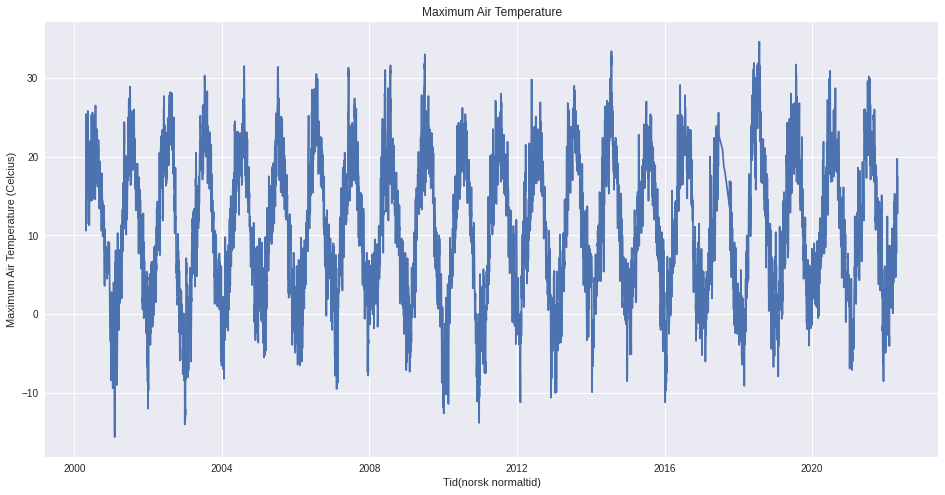

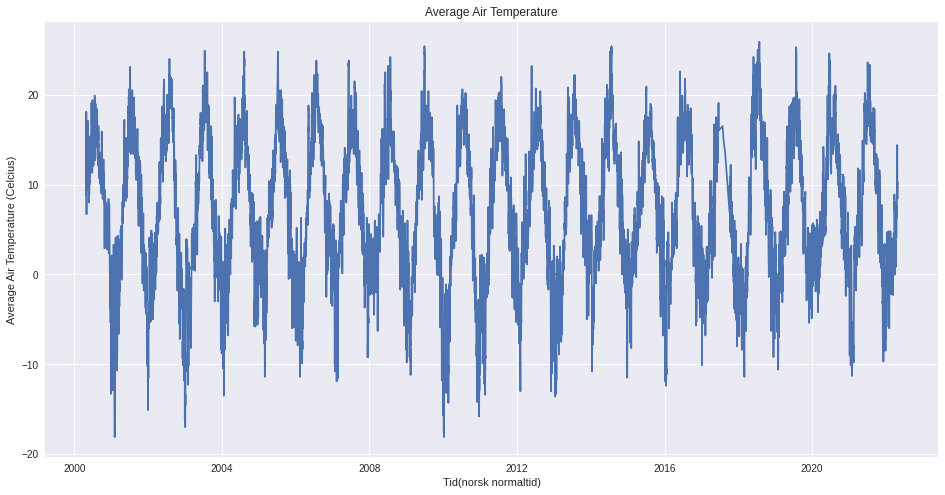

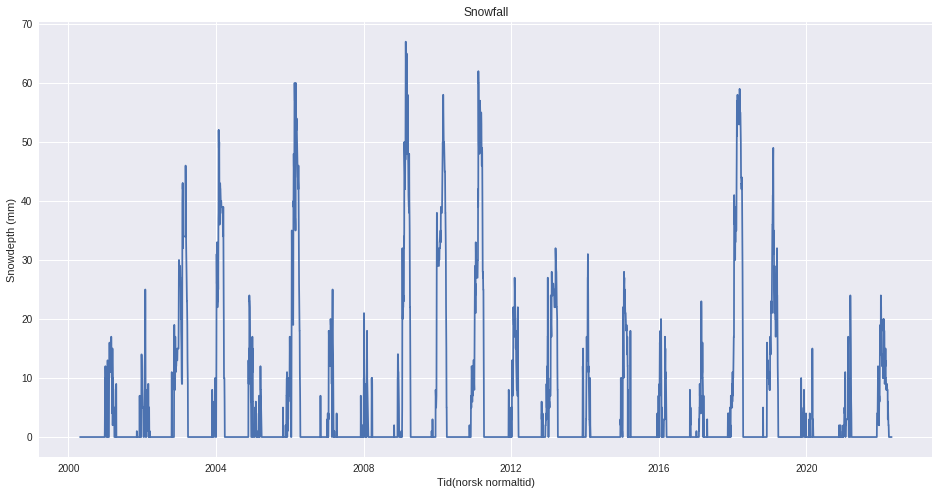

In [44]:
wet.plotData()

The first thing we see after plotting the data ranging from year 2000 to 2002 is that all the measurements have some periodic tendencies, but we are still in the time/date domain and we want to do some frequency analysis using our analysis method and discrete fourier transform.

FFT Max temp
Period:  7907.0


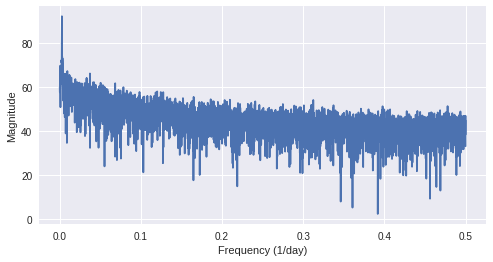

In [45]:
print("FFT Max temp")
wet.Analysis('Maksimumstemperatur (døgn)')

Now in the plot above we can see that the frequncy that "separates" itself from the rest of the noise is very close to zero. We use this value as a cutoff threshold and do an inverse fourier transform to see a cleaner version of the data. This plot contains mainly the fundamental frequency and other frequencies that create the noise in the blue plot below are removed in the green plot. This is shown in the plot below:

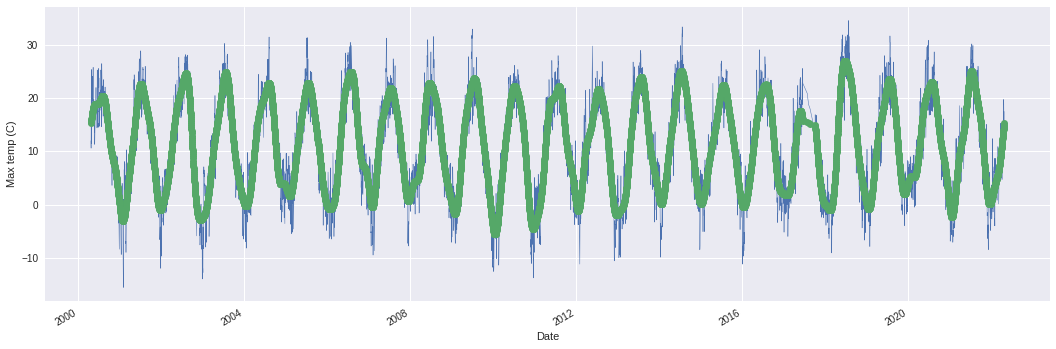

In [46]:
wet.cutandIFFT('Maksimumstemperatur (døgn)',0.01, 'Max temp (C)')

This is now repeated for the the other measurements.

FFT Avg temp
Period:  7907.0


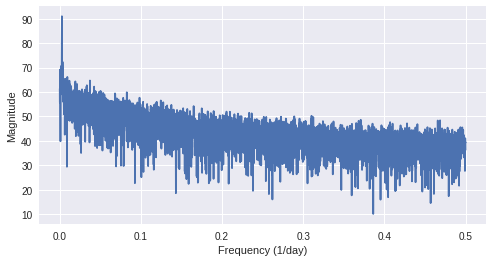

In [47]:
print("FFT Avg temp")
wet.Analysis('Middeltemperatur (døgn)')


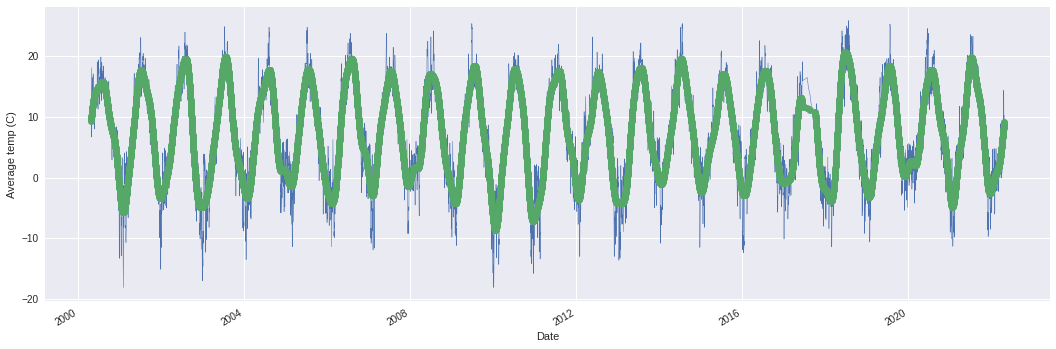

In [48]:
wet.cutandIFFT('Middeltemperatur (døgn)', 0.01, "Average temp (C)")

FFT snowdepth
Period:  7907.0


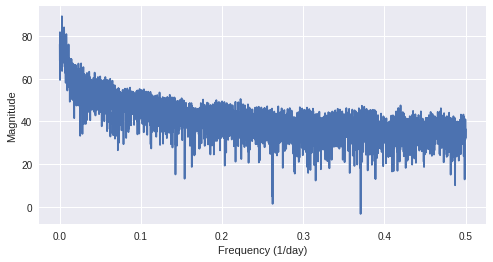

In [49]:
print("FFT snowdepth")
wet.Analysis('Snødybde')


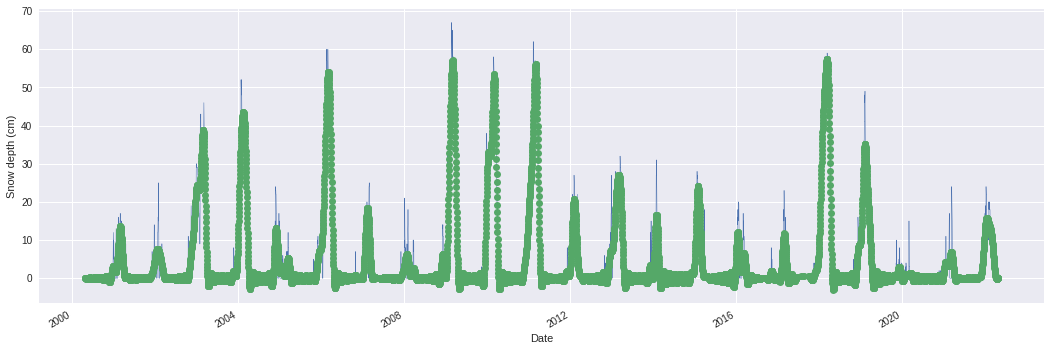

In [50]:
wet.cutandIFFT('Snødybde',0.02, "Snow depth (cm)")

FFT Precipitation
Period:  7907.0


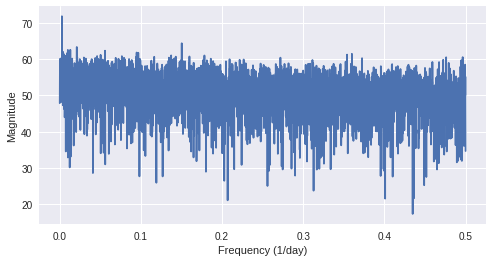

In [51]:
print("FFT Precipitation")
wet.Analysis('Nedbør (døgn)')


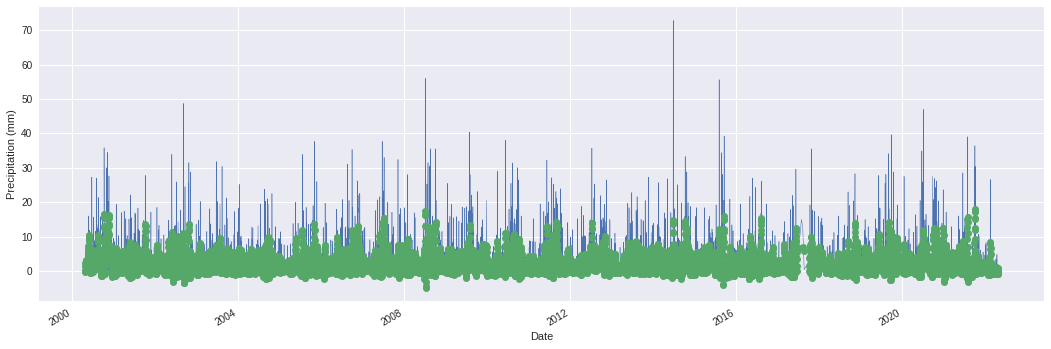

In [52]:
wet.cutandIFFT('Nedbør (døgn)',0.099, "Precipitation (mm)")

FFT avg of avg wind
Period:  7907.0


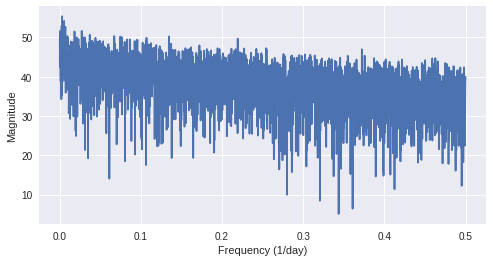

In [53]:
print("FFT avg of avg wind")
wet.Analysis('Middel av middelvind fra hovedobs. (døgn)')


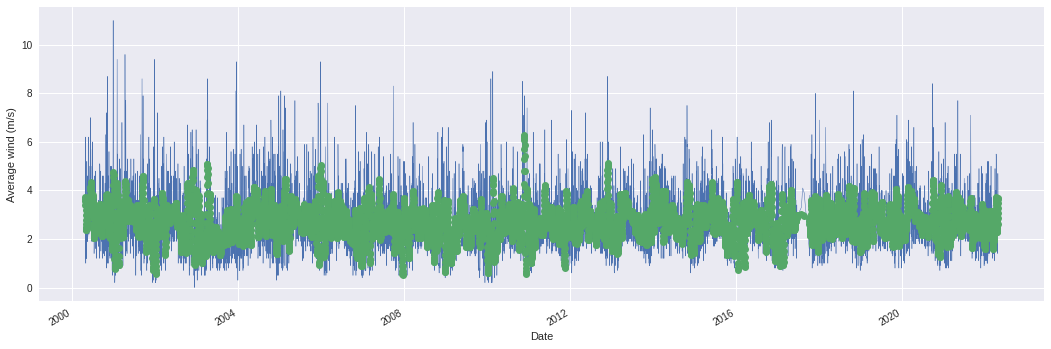

In [54]:
wet.cutandIFFT('Middel av middelvind fra hovedobs. (døgn)',0.06, "Average wind (m/s)")

In the plots above we see that most of the measurements, we can create a smooth noisfree curve representing the data, except for the two plots, which is average measurement of the wind from that weather station and the precipitation measurement. There are however some possible explanations here which i will come back to in the discussion.

### Comparison of weather stations

In this section i will do the same analysis as above, but applied on datasets from two other weather stations. One from Bergen, on the west coast of Norway and one from Tromsø in the northern region. Before i do the analysis, i would assume that the rainfall is much more significant on the west coast in Bergen, and that there is not a huge temperature difference between summer and winter.

In [55]:
wet_Bergen = WeatherAnalysis("table_BergenFlorida.xlsx")

File contains following columns: 
__________________________________
Navn
Stasjon
Maksimumstemperatur (døgn)
Middeltemperatur (døgn)
Snødybde
Nedbør (døgn)
Middel av middelvind fra hovedobs. (døgn)
__________________________________
__________________________________
_______  STATISTICS__________
       Maksimumstemperatur (døgn)  Middeltemperatur (døgn)     Snødybde  \
count                 7703.000000              7703.000000  7703.000000   
mean                    12.017032                 8.634000     0.714657   
std                      6.643513                 5.858642     3.749471   
min                     -9.100000               -11.500000     0.000000   
25%                      7.000000                 4.400000     0.000000   
50%                     11.500000                 8.400000     0.000000   
75%                     17.000000                13.200000     0.000000   
max                     33.400000                26.100000    61.000000   

       Nedbør (døgn)  Midd

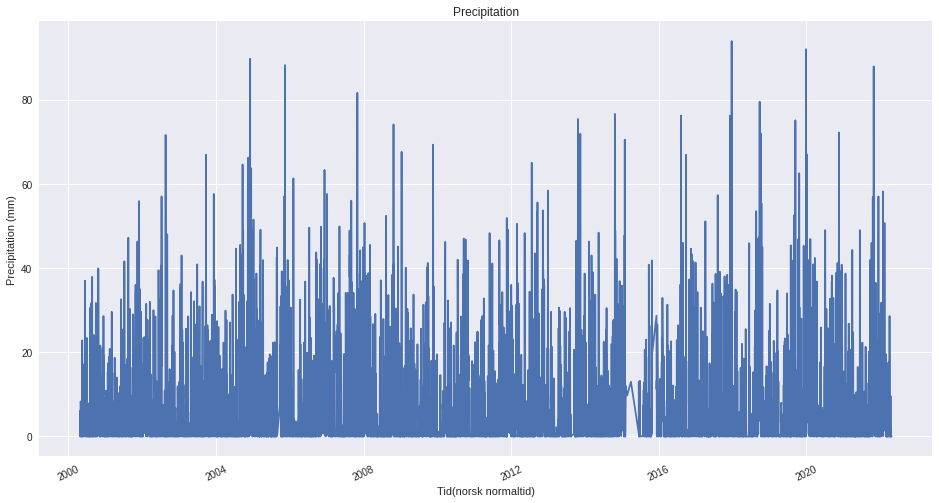

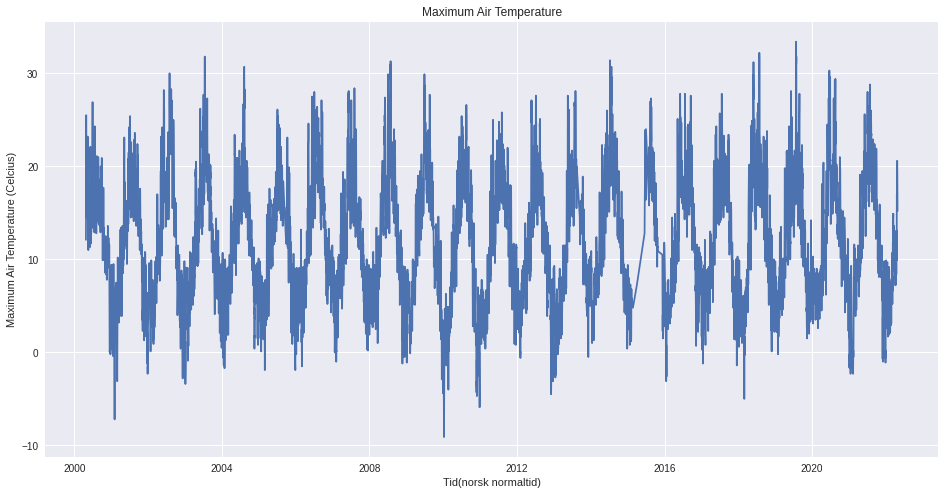

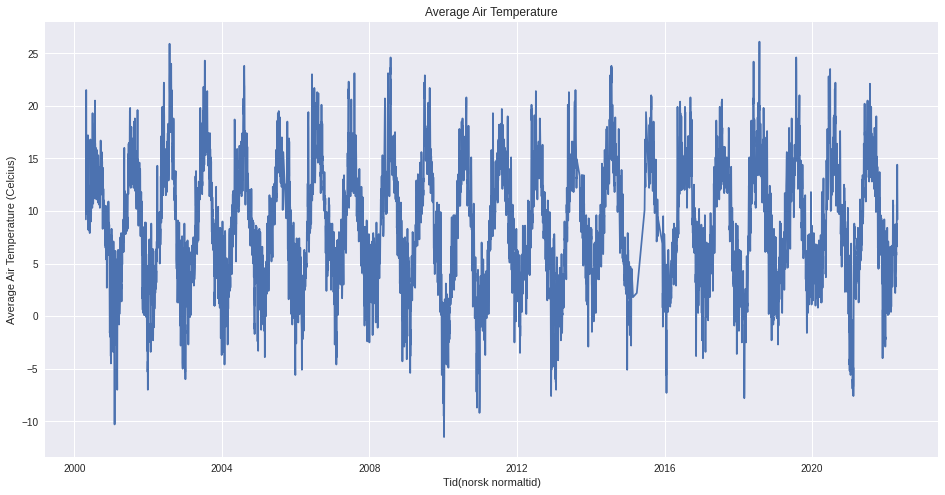

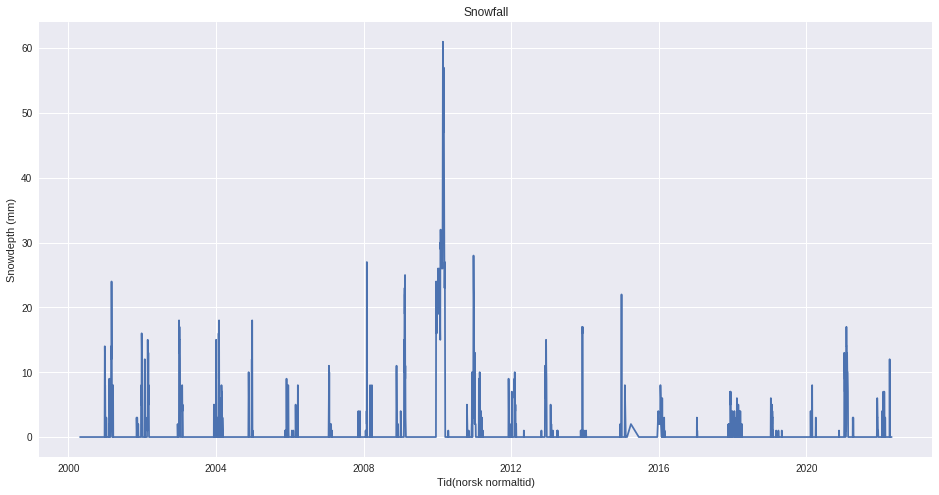

In [56]:
wet_Bergen.plotData()

FFT Max temp
Period:  7703.0


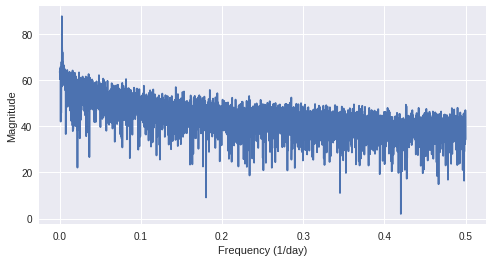

In [57]:
print("FFT Max temp")
wet_Bergen.Analysis('Maksimumstemperatur (døgn)')

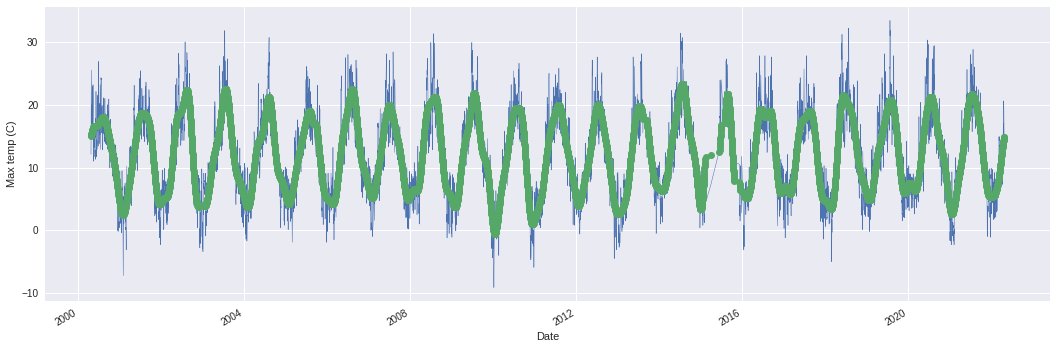

In [58]:
wet_Bergen.cutandIFFT('Maksimumstemperatur (døgn)',0.01,'Max temp (C)')

FFT Avg temp
Period:  7703.0


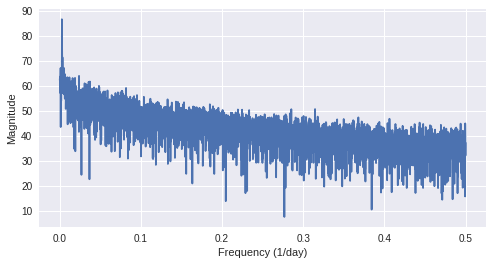

In [59]:
print("FFT Avg temp")
wet_Bergen.Analysis('Middeltemperatur (døgn)')

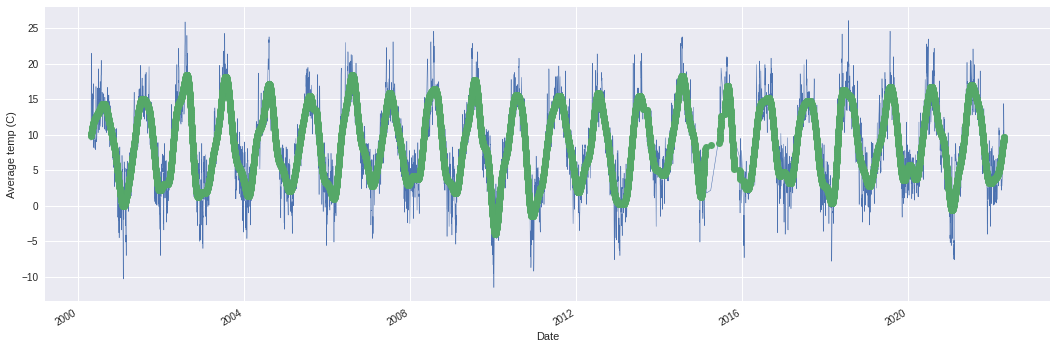

In [60]:
wet_Bergen.cutandIFFT('Middeltemperatur (døgn)', 0.01,"Average temp (C)")

FFT snowdepth
Period:  7703.0


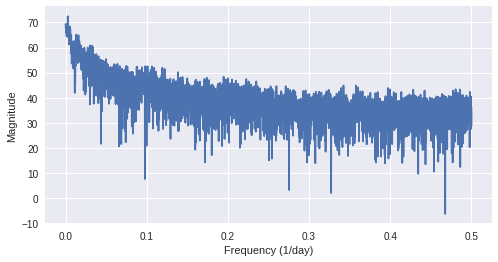

In [61]:
print("FFT snowdepth")
wet_Bergen.Analysis('Snødybde')

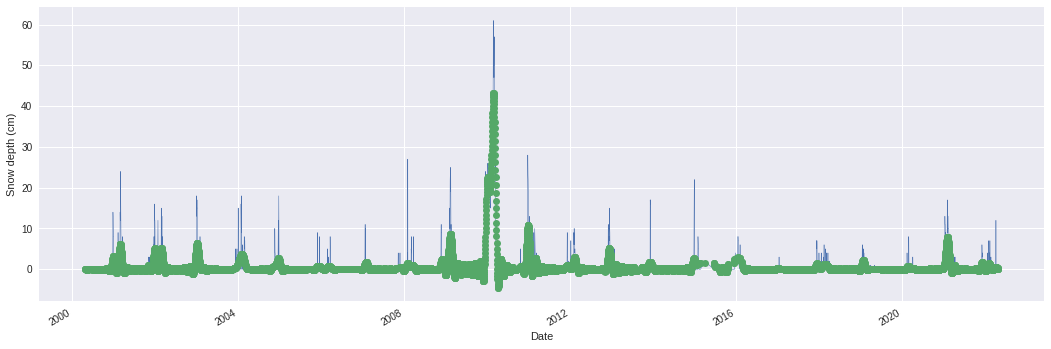

In [62]:
wet_Bergen.cutandIFFT('Snødybde',0.02,"Snow depth (cm)")

FFT Precipitation
Period:  7703.0


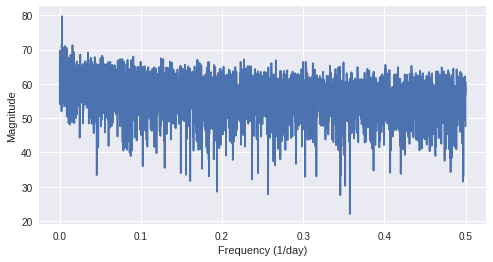

In [63]:
print("FFT Precipitation")
wet_Bergen.Analysis('Nedbør (døgn)')


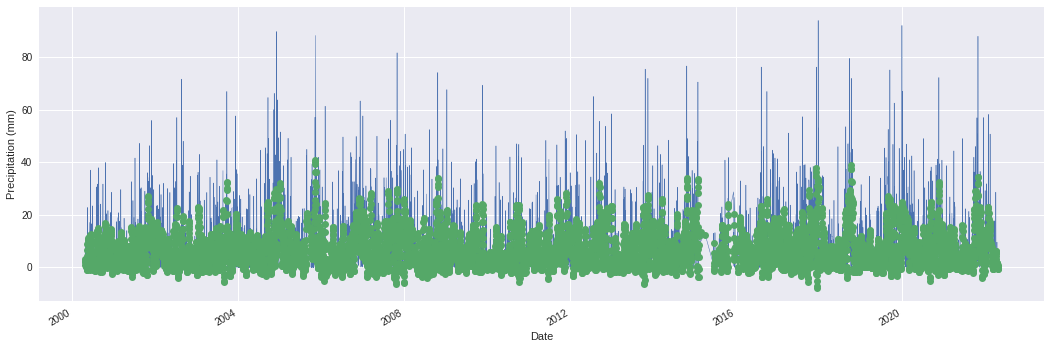

In [64]:
wet_Bergen.cutandIFFT('Nedbør (døgn)',0.099, "Precipitation (mm)")

FFT avg of avg wind
Period:  7703.0


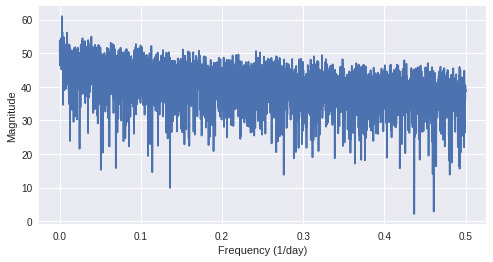

In [65]:
print("FFT avg of avg wind")
wet_Bergen.Analysis('Middel av middelvind fra hovedobs. (døgn)')

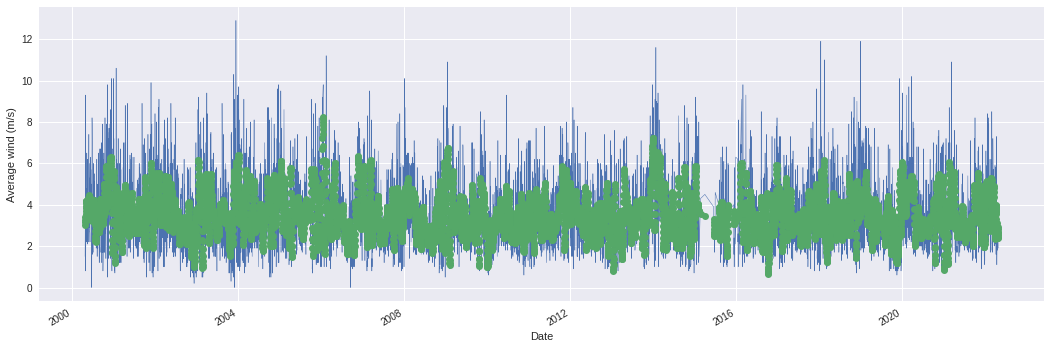

In [66]:
wet_Bergen.cutandIFFT('Middel av middelvind fra hovedobs. (døgn)',0.06,"Average wind (m/s)")

From the plots and analysis of the data from the weather station in Bergen we can see that our assumptions where not that for off. Below i have run the code for the Tromsø weather station and we will do a quick comparison of the data and look at different time periods in more detail.

In [67]:
wet_Tr = WeatherAnalysis("table_Tromso.xlsx")


File contains following columns: 
__________________________________
Navn
Stasjon
Maksimumstemperatur (døgn)
Middeltemperatur (døgn)
Snødybde
Nedbør (døgn)
Middel av middelvind fra hovedobs. (døgn)
__________________________________
__________________________________
_______  STATISTICS__________
       Maksimumstemperatur (døgn)  Middeltemperatur (døgn)     Snødybde  \
count                 7050.000000              7050.000000  7050.000000   
mean                     5.682993                 2.867291    29.528511   
std                      7.067797                 6.342419    36.133288   
min                    -15.200000               -16.300000     0.000000   
25%                      0.500000                -1.800000     0.000000   
50%                      4.700000                 2.300000    12.000000   
75%                     10.700000                 7.700000    56.000000   
max                     29.700000                21.200000   169.000000   

       Nedbør (døgn)  Midd

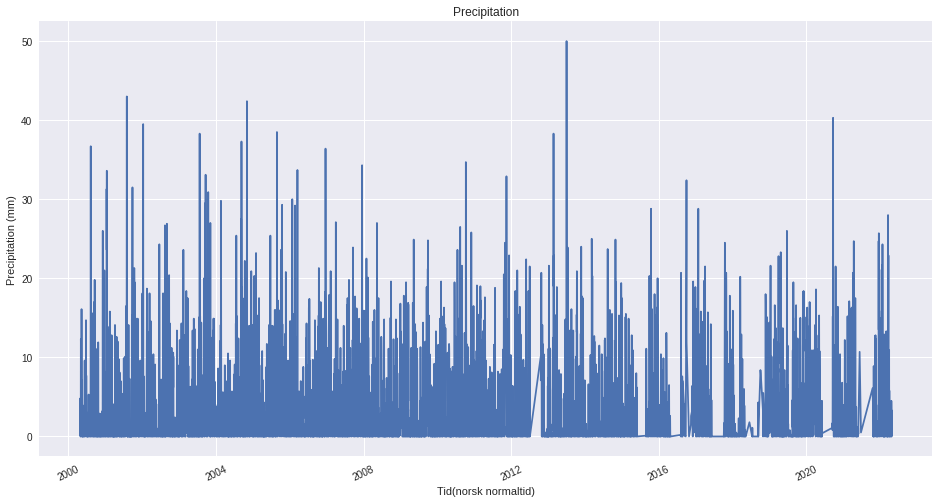

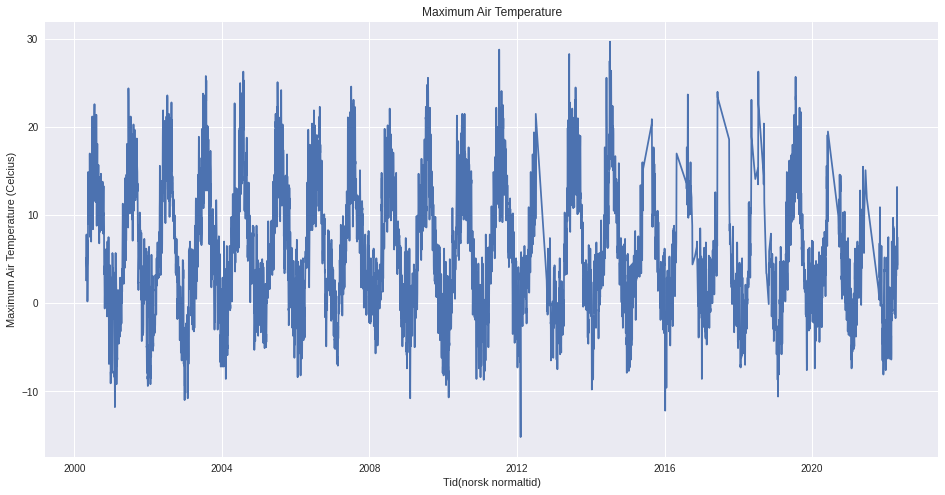

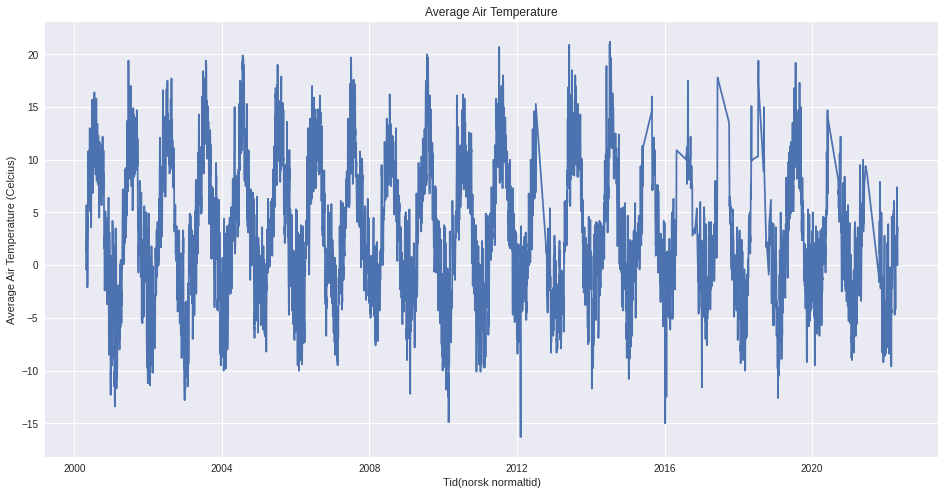

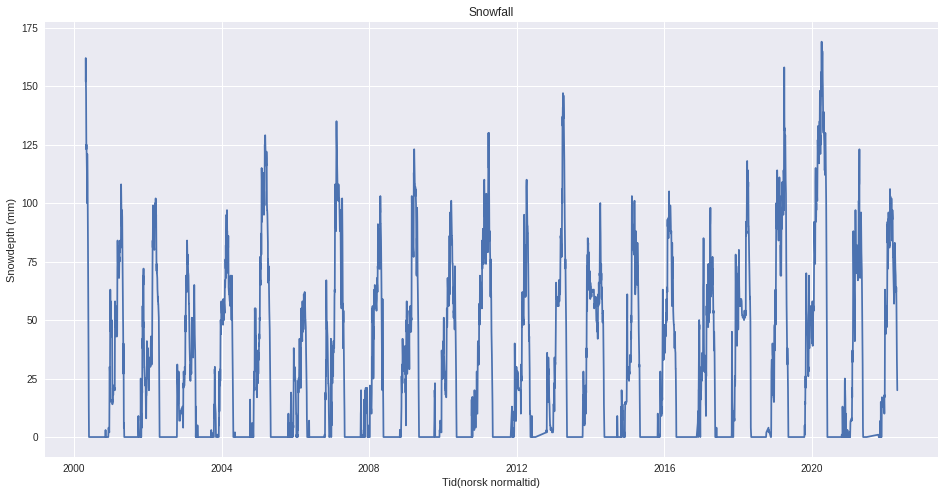

In [68]:
wet_Tr.plotData()


FFT Max temp
Period:  7050.0


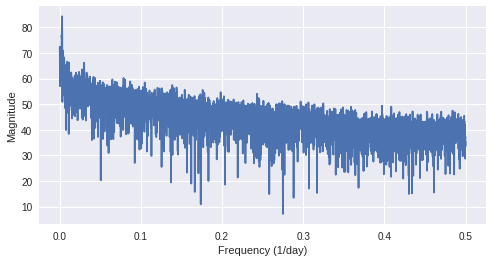

In [69]:
print("FFT Max temp")
wet_Tr.Analysis('Maksimumstemperatur (døgn)')

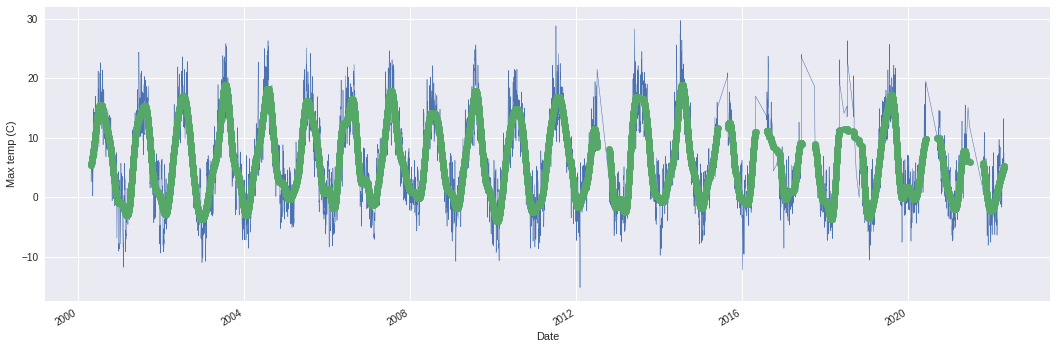

In [70]:
wet_Tr.cutandIFFT('Maksimumstemperatur (døgn)',0.01,'Max temp (C)')

FFT Avg temp
Period:  7050.0


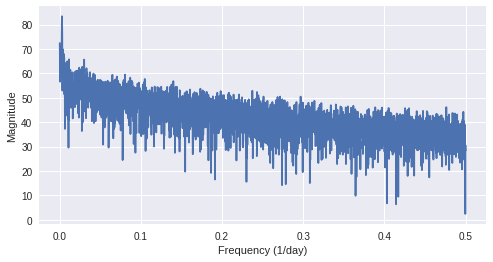

In [71]:
print("FFT Avg temp")
wet_Tr.Analysis('Middeltemperatur (døgn)')

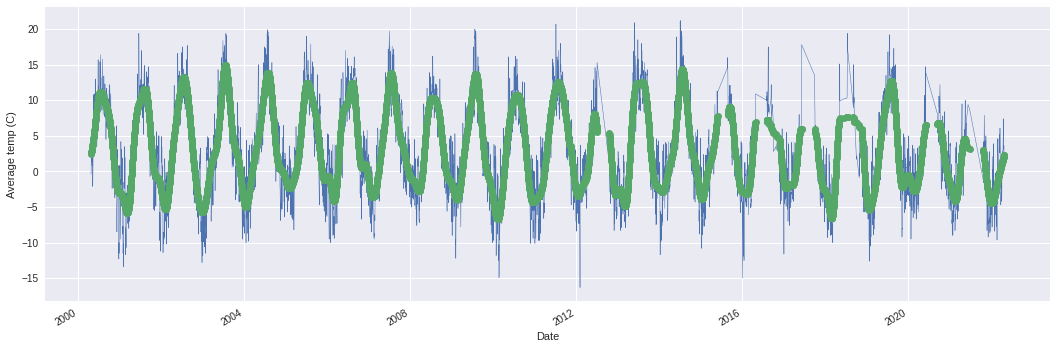

In [72]:
wet_Tr.cutandIFFT('Middeltemperatur (døgn)', 0.01,"Average temp (C)")

FFT snowdepth
Period:  7050.0


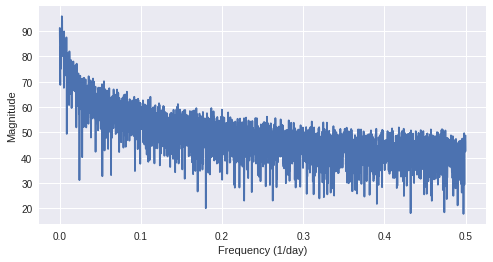

In [73]:
print("FFT snowdepth")
wet_Tr.Analysis('Snødybde')

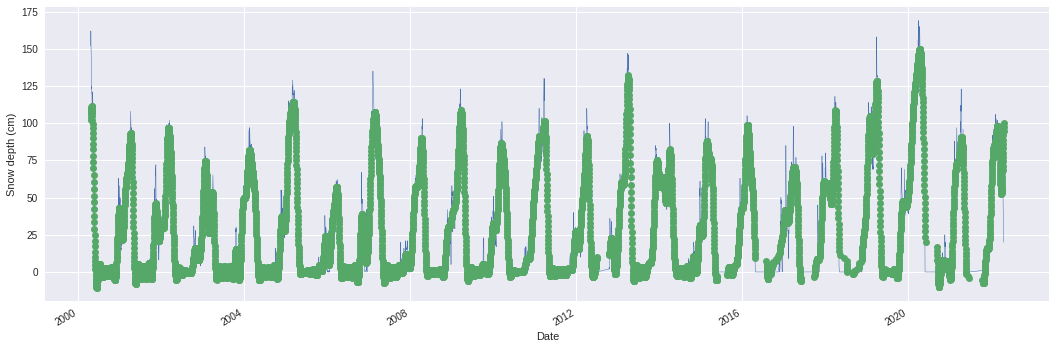

In [74]:
wet_Tr.cutandIFFT('Snødybde',0.02,"Snow depth (cm)")

FFT Precipitation
Period:  7050.0


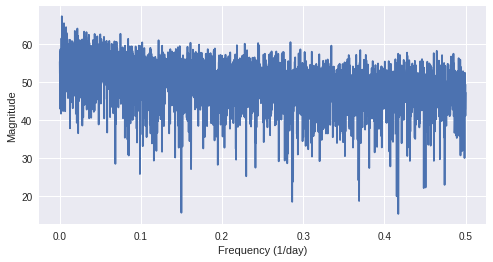

In [75]:
print("FFT Precipitation")
wet_Tr.Analysis('Nedbør (døgn)')

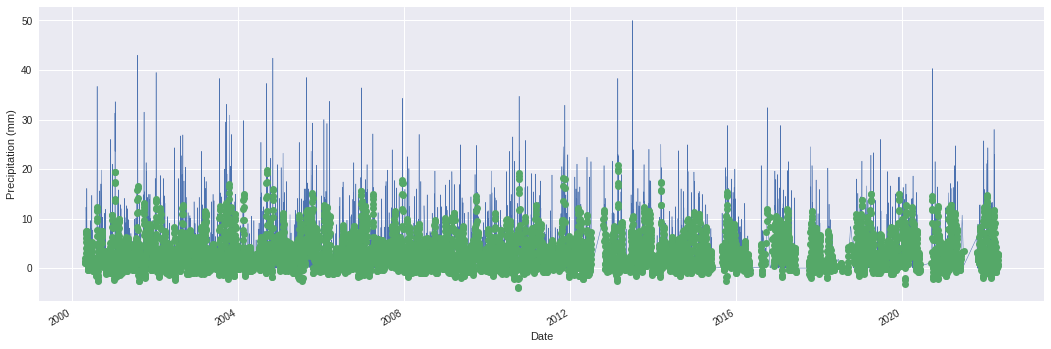

In [76]:
wet_Tr.cutandIFFT('Nedbør (døgn)',0.099,"Precipitation (mm)")

FFT avg of avg wind
Period:  7050.0


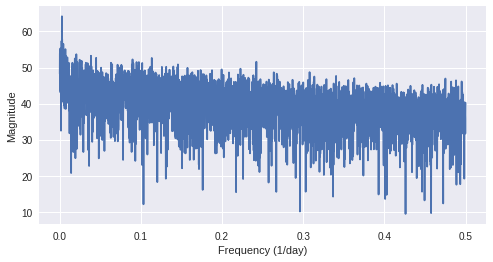

In [77]:
print("FFT avg of avg wind")
wet_Tr.Analysis('Middel av middelvind fra hovedobs. (døgn)')

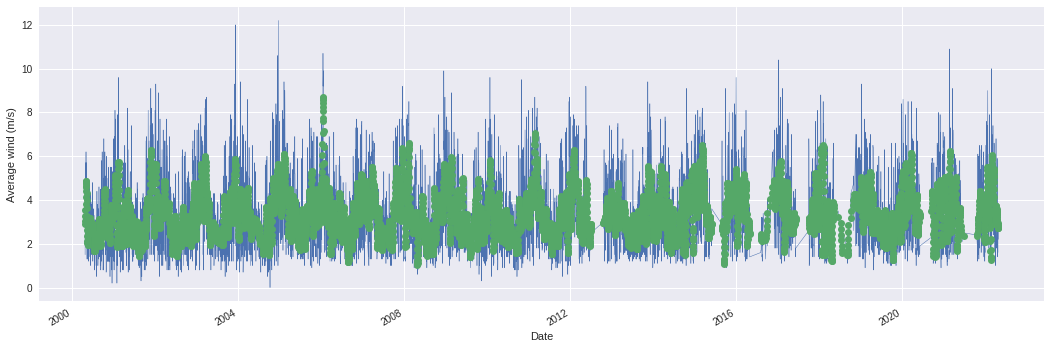

In [78]:
wet_Tr.cutandIFFT('Middel av middelvind fra hovedobs. (døgn)',0.06,"Average wind (m/s)")

# Discussion and conclusion


In the images below we can see a quick summary of some basic statistics of each file. The first images is for the Blindern station in Oslo, second image is for Bergen station and third image is for the Tromsø station. 

# Blindern
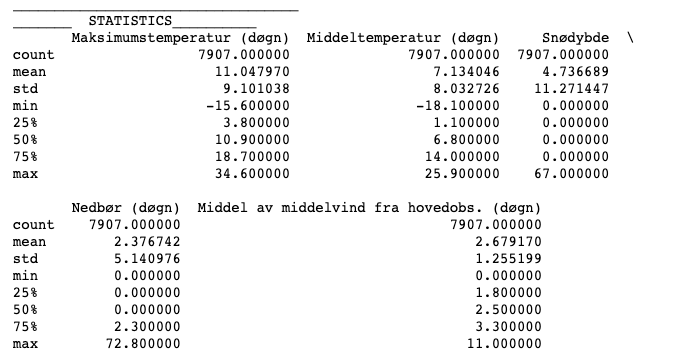

# Bergen
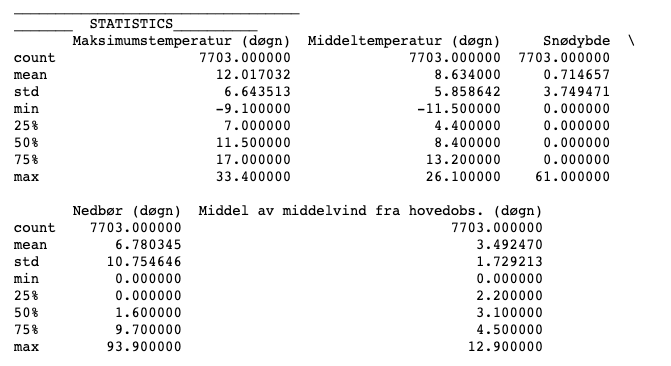

# Tromsø
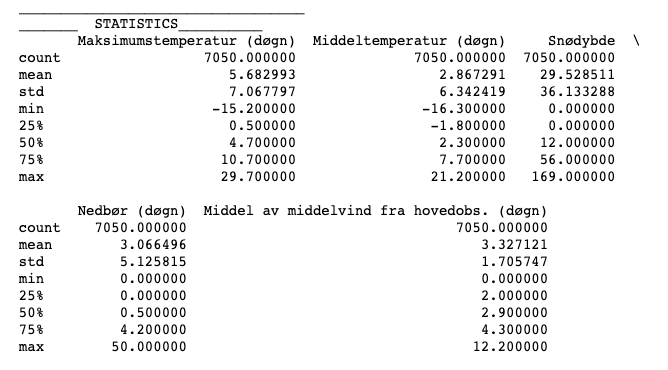

Looking at the numbers above we can see that the west coast of Norway (Bergen station) has highest precipitation measured in mm. This is as expected as Bergen is a coastal city surrounded by mountains. We also assumed Bergen would not get that cold and this is reflected well in the snowdepth. We can see that the mean of the snowdepth in Oslo was about 4 cm and for Bergen it was less than 1 cm, while for Tromsø which is located in the North it was almost 30 cm!

In the beginning i mentioned that I wanted to answer some questions based on the results of the analysis, such as if the seasons has been delayed or if there is any signs of climate change in the past 20 years given the data from these 3 weather station. There are many methods that meterologists would use to look for changes in the climate, but i will not use such methods. Instead, im thinking that the climate follows a cyclical/periodic pattern. This

Based on my results i have decided to look at the average temperature too look for any anomalies. Below i have the three plots for the three stations showing the average temperature. And next, i will run the code again but "zoom" in from the year where the change in the pattern occurs.

# Tromsø
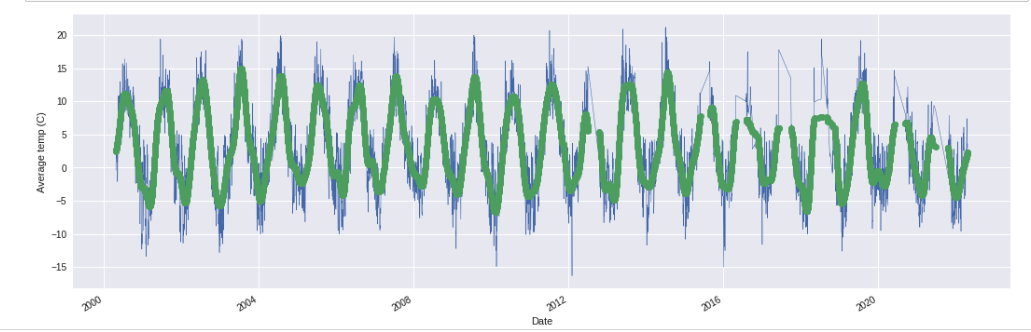

# Bergen
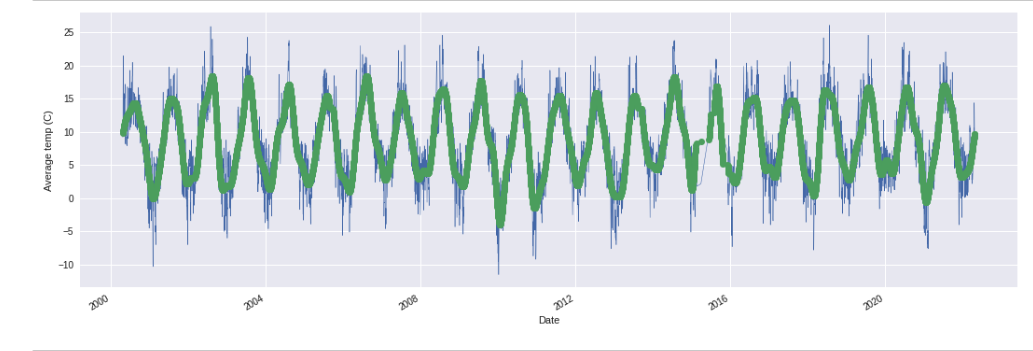

# Blindern, Oslo
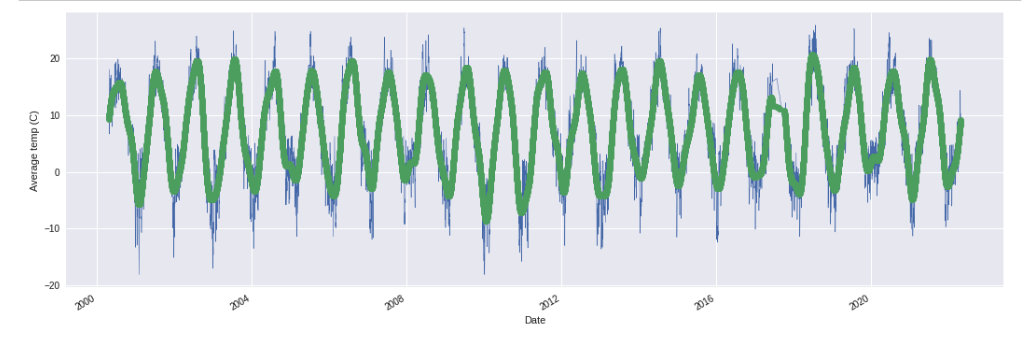

Based on the plots we can see that the pattern is periodic but with some delays, especially arround 2016. This confirms what we guessed in the beginning, but not 100%. This delay in the period can come from some issues from the measurements or the instruments, but since its showing in all three stations spread across the country i assume its not a malfunction, but rather a change in the average temperature pattern. 

### Zooming in on certain years of the data

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import matplotlib.transforms as mtransforms
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from numpy.fft import rfft, irfft, rfftfreq
from scipy import pi, signal, fftpack

class WeatherAnalysis():
    def __init__(self,inputData):
        self.df = pd.read_excel(inputData)
        self.df.replace('-',np.nan, inplace = True)
        #self.df["Tid(norsk normaltid)"] = self.df["Tid(norsk normaltid)"].astype(str)
        #self.df['ConvertedDate'] = self.df['Tid(norsk normaltid)'].dt.strftime('%d/%m/%Y')
        self.df['Tid(norsk normaltid)'] = pd.to_datetime(self.df['Tid(norsk normaltid)'], errors='coerce')
        self.df['Tid(norsk normaltid)'] = self.df['Tid(norsk normaltid)'].dt.strftime('%d/%m/%Y')
        self.df["Tid(norsk normaltid)"] = self.df["Tid(norsk normaltid)"].astype("datetime64")
        self.df = self.df.set_index("Tid(norsk normaltid)")
        #self.df.drop(self.df[self.df['Nedbør (døgn)']== '-'].index, inplace = True)
        #self.df.replace(np.nan,'-', inplace = True)
        self.df.dropna(inplace= True)
        self.df = self.df.loc[self.df.index > '2016']
    
        print("File contains following columns: ")
        print("__________________________________")
        for col in self.df.columns.values.tolist():
            print(col)
        print("__________________________________")
        print("__________________________________")
        print("_______  STATISTICS__________")
        print(self.df.describe())
        
        

    
    #In the function below we plot the timeseries data read from the datafile that is read as pandas dataframe
    #I have "hardcoded" this below since the column names are equal for all files collected from the 
    #data source, this is not the optimal way if you want to create a class that works universally ofcourse.
    def plotData(self):
        plt.style.use('seaborn')
        plt.rcParams["figure.figsize"] = (16, 8)
        plt.title("Precipitation")
        sns.lineplot(x = self.df.index, y = self.df['Nedbør (døgn)'], data = self.df)
        plt.ylabel("Precipitation (mm)")
        plt.xticks(rotation = 25)
        plt.show()
        
        plt.title("Maximum Air Temperature")
        sns.lineplot(x = self.df.index, y = self.df['Maksimumstemperatur (døgn)'], data = self.df)
        plt.ylabel("Maximum Air Temperature (Celcius)")
        plt.show()
        
        
        plt.title("Average Air Temperature")
        sns.lineplot(x = self.df.index, y = self.df['Middeltemperatur (døgn)'], data = self.df)
        plt.ylabel("Average Air Temperature (Celcius)")
        plt.show()
        
        plt.title("Snowfall")
        sns.lineplot(x = self.df.index, y = self.df['Snødybde'], data = self.df)
        plt.ylabel("Snowdepth (mm)")
        plt.show()
        
    #Here i do the fourier analysis
    def Analysis(self,inp):
        samplerate = 1
        N = self.df.shape[0]
        f_samp = samplerate
        T = N/f_samp
        print("Period: ",T)
        dt = 1/f_samp
        fftVal  = np.fft.fft(self.df[inp])
        measFFT = np.abs(fftVal) ** 2
        fftfreq = np.fft.fftfreq(N,dt)
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(fftfreq[fftfreq > 0], 10 * np.log10(measFFT[fftfreq > 0]))
        #ax.set_xlim(0, 5)
        ax.set_xlabel('Frequency (1/day)')
        ax.set_ylabel('Magnitude')


    #Inverse Fourier transform and cutoff
    def cutandIFFT(self,inp,cutOff, ylab):

        samplerate = 1
        N = self.df.shape[0]
        f_samp = samplerate
        T = N/f_samp
        dt = 1/f_samp
        fftVal  = np.fft.fft(self.df[inp])
        measFFT = np.abs(fftVal) ** 2
        fftfreq = np.fft.fftfreq(N,dt)
        

        fftCopy = fftVal.copy()
        fftCopy[np.abs(fftfreq) > cutOff] = 0

        temp_slow = np.real(np.fft.ifft(fftCopy))
        fig, ax = plt.subplots(1, 1, figsize=(18, 6))
        self.df[inp].plot(ax=ax, lw=.5)
        ax.plot_date(self.df.index, temp_slow)
        ax.set_xlabel('Date')
        ax.set_ylabel(ylab)
        plt.show()

        

File contains following columns: 
__________________________________
Navn
Stasjon
Maksimumstemperatur (døgn)
Middeltemperatur (døgn)
Snødybde
Nedbør (døgn)
Middel av middelvind fra hovedobs. (døgn)
__________________________________
__________________________________
_______  STATISTICS__________
       Maksimumstemperatur (døgn)  Middeltemperatur (døgn)     Snødybde  \
count                 2193.000000              2193.000000  2193.000000   
mean                    10.895030                 6.925217     4.248974   
std                      9.062914                 7.885074    10.549632   
min                    -11.200000               -12.400000     0.000000   
25%                      3.700000                 1.100000     0.000000   
50%                      9.800000                 5.700000     0.000000   
75%                     18.800000                13.700000     2.000000   
max                     34.600000                25.900000    59.000000   

       Nedbør (døgn)  Midd

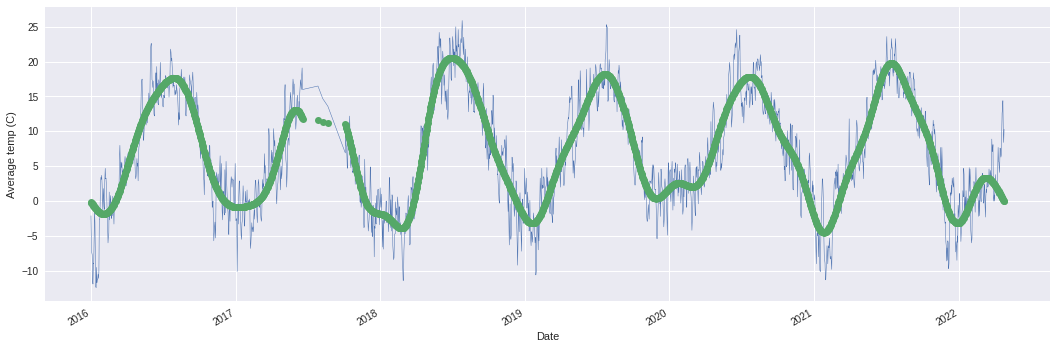

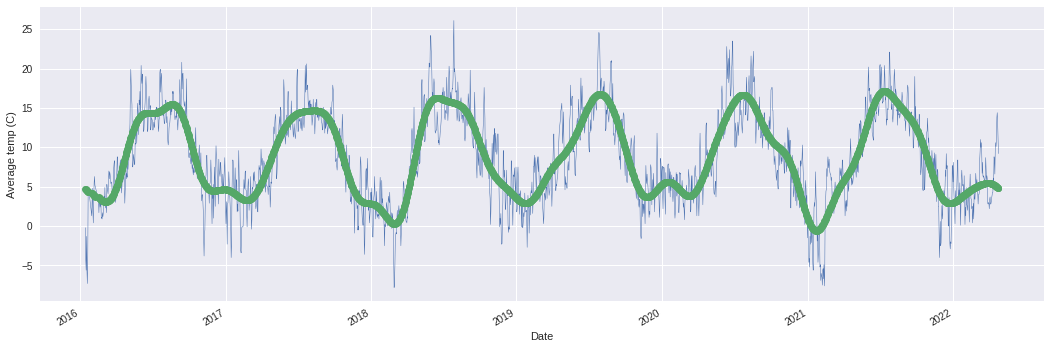

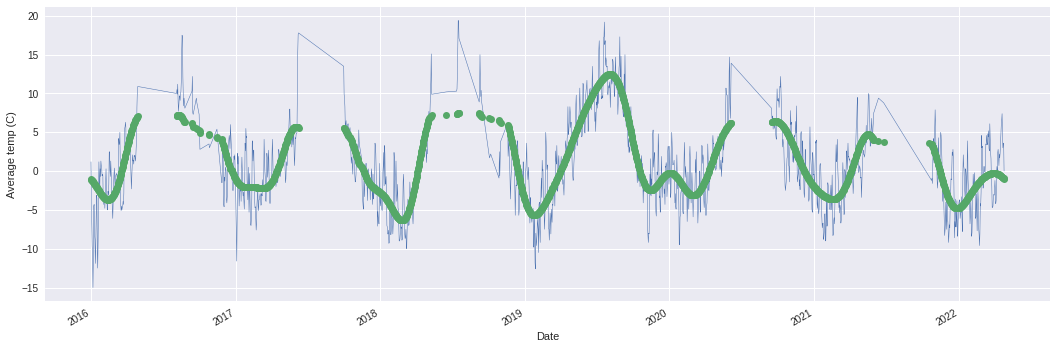

In [82]:
blind = WeatherAnalysis("table_Blindern.xlsx")
bergen = WeatherAnalysis("table_BergenFlorida.xlsx")
tromso = WeatherAnalysis("table_Tromso.xlsx")

blind.cutandIFFT('Middeltemperatur (døgn)', 0.01,"Average temp (C)")
bergen.cutandIFFT('Middeltemperatur (døgn)', 0.01,"Average temp (C)")
tromso.cutandIFFT('Middeltemperatur (døgn)', 0.01,"Average temp (C)")

Based on the zoomed in plots of the average temperature we observe first that there is changes in the weather, but another observation is that the cutoff is the same as earlier eventhough we have a much smaller dataset, and it looks like the smoothed line is not matching the data as good. By looking at the zoomed in data the temperature fluctiations become more apparent and we can see you they change based on the seasons. Changing the samplerate here from 1 day and increasing it would make that more visual simply by increasing the resolution. All in all, i would say that fourier analysis has helped me to gain a better insight in the weather data and the different climate patterns and to actually see some signs of delay in the seasons. In the future i would like to extend my WeatherAnalysis class to also do wavelet analysis as i think it would look more sensible for a user when it comes to weather data. 

# References

[1] Physics of Oscillations and Waves, Arnt Inge Vistnes,2008

[2] https://www.worldatlas.com/articles/how-high-is-the-earth-s-atmosphere.html 